# Programming for Economics

## Problem Set 06 - Week 7 - Group 02

17/03/2023

### Problem 1.

In [1]:
# Import dependencies 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy
import quantecon as qe

import warnings
warnings.filterwarnings('ignore')

__Comment:__ Although a more procedural approach also works well in the context of this problem, we wanted to experiment with an alternative programming approach: Object Oriented Programming (OOP), which comes with some added benefits:
1. Reusability: its possible for us to easily reapply the defined ApproxFunc class for future problems or functions.
2. Encapsulation: prevent accidental to the data or variable of interest throughout answering each part.
3. Understandability: in redefining the problem as a system of objects, attributes, and methods, we can better understand how each part interacts with the others. 

In [2]:
class ApproxFunc:
    def __init__(self, ActualFunc, bounds):
        self.ActualFunc = ActualFunc
        self.lower_bound, self.upper_bound = bounds
    
    def ChebyshevPoly(self, n,x):
        a = self.lower_bound
        b = self.upper_bound
        m = n + 1                    #Number of chebyshev roots

        z = [-np.cos((2*k-1)/(2*m)*np.pi) for k in range(1,m+1)]  #projected x-values of the chebyshev nodes
        xk = [(z_i +1)*(b - a)/2 + a for z_i in z]                #Adjust nodes for intervals other than [-1,1]
        y = [self.ActualFunc(x_i) for x_i in xk]                 #Actual y-values at those intervals

        def T(n, x):
            return np.cos(n*np.arccos(x))
    
        # Calculate the chebyshev coefficients:
        c = []
        for i in range(m+1):
            num = np.sum(y[k]*T(i,z[k]) for k in range(m))
            den = np.sum(T(i,z[k])**2 for k in range(m))
            ci = num / den
            c.append(ci)
            
        #Generate approximate values over an evenly spaced points
        def f_approx(x):
            return np.sum(c[i]*T(i, 2*(x-a)/(b-a)-1) for i in range(n+1))
    
        return f_approx(x)
    
    def LagrangePoly(self, n, x):
        a = self.lower_bound
        b = self.upper_bound
        
        def vandermonde(X):
            n = len(X)
            V = [[x_i**s for s in range(n)] for x_i in X]
            return V
    
        X = np.linspace(a,b,n)   #Evenly spaced  interpolation nodes
        V_matrix = vandermonde(X)
        Y_vector = self.ActualFunc(X)
        a_coeff = np.linalg.solve(V_matrix,Y_vector)   
       
        #Generate approximate values over an evenly spaced points        
        def f_approx(x):
            return sum([a_coeff[i] * x**(i) for i in range(len(a_coeff))])
        
        return f_approx(x)
    
    def LinearInterp(self, n, x):
        a = self.lower_bound
        b = self.upper_bound

        X = np.linspace(a,b,n)  #Evenly spaced interpolation nodes
        Y = self.ActualFunc(X)
        
        def f_approx(x):
            return np.interp(x, X, Y)  #Use the pre-defined np.interp implementation
        
        return f_approx(x)
    
    def CubicSplines(self, n, x):
        '''Number of Interpolation nodes (X) must be > 1 '''
        if n <= 1:
            raise ValueError("CubicSplines: n must be greater than 1.")
            
        a = self.lower_bound
        b = self.upper_bound
        
        X = np.linspace(a,b,n)  #Evenly spaced interpolation nodes, must be greater than 1
        Y = self.ActualFunc(X)
        
        def f_approx(x):
            return scipy.interpolate.CubicSpline(X,Y)(x)
        
        return f_approx(x)
    
    
    def plot(self, n, x, method="Chebyshev", suppress_legend=False):         #Default to Chebyshev  
        
        if isinstance(n, int):   #Allows us to pass n=1 or n=[1,2,3] for multiple lines in one plot.  
            n = [n]
        
        fig, ax = plt.subplots()
        
        y_actual = self.ActualFunc(x)
        ax.plot(x, y_actual, label="Actual", color="black", linestyle="dotted")
          
        #Approximate f over various n.
        for i in n:
            if method == "Chebyshev":    
                y_approx = self.ChebyshevPoly(i,x)
            elif method == "Lagrange":
                y_approx = self.LagrangePoly(i,x)    
            elif method == "Linear":
                y_approx = self.LinearInterp(i,x)
            elif method == "Spline":
                y_approx = self.CubicSplines(i,x)
            ax.plot(x, y_approx, label=f"n={i}")
        
        if suppress_legend==False:  #Useful for when n_list gets large
            plt.legend()
            
        ax.set_title(f"{method} Approximation of {self.ActualFunc.__name__}")
        return plt.show()

    def plot_deviation(self, n, x, method="Chebyshev", suppress_legend=False):
       
        if isinstance(n, int):   #Allows us to pass n=1 or n=[1,2,3] for multiple lines in one plot.  
            n = [n]

        fig, ax = plt.subplots()
        
        #Approximate f over various n.
        y_actual = self.ActualFunc(x)
        
        for i in n:
            if method == "Chebyshev":    
                y_approx = self.ChebyshevPoly(i,x)
            elif method == "Lagrange":
                y_approx = self.LagrangePoly(i,x)    
            elif method == "Linear":
                y_approx = self.LinearInterp(i,x)
            elif method == "Spline":
                y_approx = self.CubicSplines(i,x)
            error = abs(y_approx - y_actual)
            ax.plot(x, error, label=f"n={i}", linewidth=0.8)
            ax.fill_between(x,0,error, alpha=0.3)

        if suppress_legend==False:  #Useful for when n_list gets large
            plt.legend()
            
        ax.set_title(f"{method} Deviation Error in {self.ActualFunc.__name__}")
        return plt.show()
    
    def plot_node_error(self, n_list, x):
       
        all_methods = ["Chebyshev", "Lagrange", "Linear", "Splines"]
        fig, ax = plt.subplots()
     
       #Approximate f over various n and plot
        y_actual = self.ActualFunc(x)
       
        for i in all_methods:
            error_bin = []
            for j in n_list:
                if i == "Chebyshev":    
                    y_approx = self.ChebyshevPoly(j,x)
                elif i == "Lagrange":
                    y_approx = self.LagrangePoly(j,x)    
                elif i == "Linear":
                    y_approx = self.LinearInterp(j,x)
                elif i == "Splines":
                    y_approx = self.CubicSplines(j,x)
                error = (1/len(x)) * sum((y_actual-y_approx)**2)
                error_bin.append(error)
            ax.plot(np.log(n_list), np.log(error_bin), label=f"{i}")

        plt.legend()
        ax.set_title(f"Approx. Error of {self.ActualFunc.__name__} for Various Methods as n Grows (Log-Log)")
        ax.set_xlabel("Log(Number of Interpolation Nodes) [Log(n)]")
        ax.set_ylabel("Log(Approximation Error)")
        return plt.show()
    
        #Additional Methods that allow us to edit an instance's attributes 
    def set_bounds(self, bounds):
        self.bounds = bounds        

    def set_ActualFunc(self, ActualFunc):
        self.ActualFunc = ActualFunc  

#### (a) Approximate each of these functions with Chebyshev polynomials, Lagrange polynomials, linear interpolation, and cubic splines. Try a variety of grid sizes $(n = 5, 10, 20, 50, 100)$ and plot the resulting approximations against the true function. Plot the approximation error $f-f^{\hat{}}$ over the relevant domains. How well do the methods seem to be working? Note: you will need to write your own implementation of Chebyshev polynomials and Lagrange interpolation to do this, however you should feel free to use a standard implementation of linear interpolation/cubic splines.

In this exercise we decided to arbitrarily choose our ns to best illustrate how quickly each method converges to a good approximation. We did this because for most of the functions there wasn't really a difference in the approximation accuracy after a realtively small n.

In [3]:
# Define Function #1
def f1(x):
    return np.exp(2*x+2)

lower_b = -1
upper_b = 1

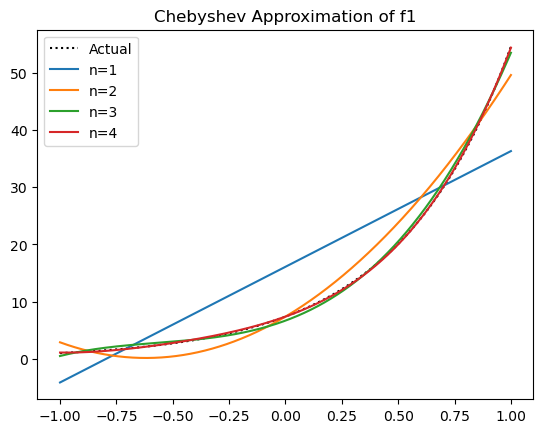

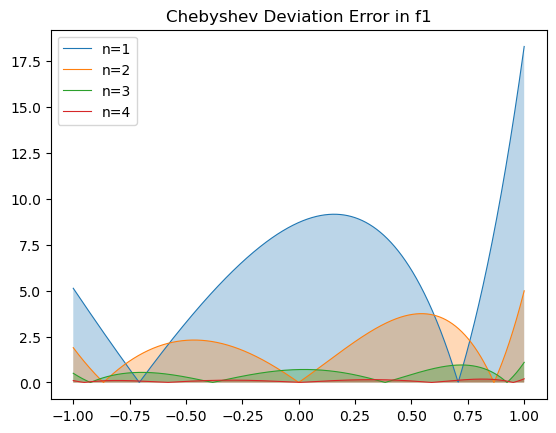

In [4]:
# Function #1: Chebyshev Polynomials

# start by creating an instance of the class
f1_approx = ApproxFunc(f1, bounds=[lower_b, upper_b])

# set parameters
n = [1,2,3,4]
x = np.linspace(lower_b, upper_b, 1000)

# call the plot methods
f1_approx.plot(n, x, method = "Chebyshev")
f1_approx.plot_deviation(n, x, method = "Chebyshev")

__Comment:__ We plot $n$ from 1 to 4, because after $n=4$, Chebyshev approximates this simple function extremeley accurately. 

The hills and ravines of the simple deviation plot are due to the __0__ deviation at each interpolation nodes. By increasing the number of interpolation nodes, we force the approximation to conform to the underlying function more faithfully, creating plateaus in the deviation plot. 

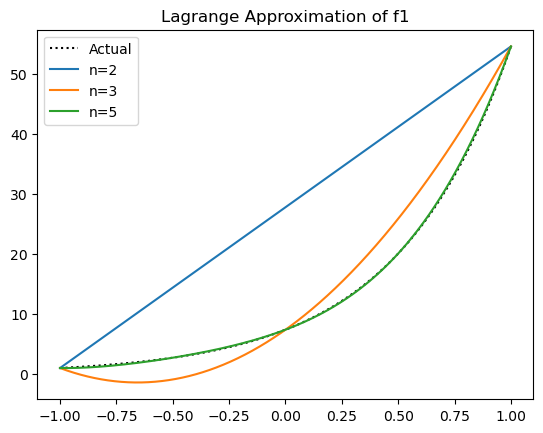

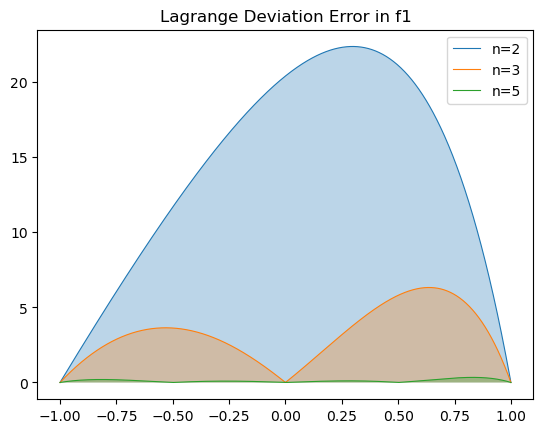

In [5]:
# Function #1: Lagrange Polynomials
n=[2,3,5]

f1_approx.plot(n, x, method = "Lagrange")
f1_approx.plot_deviation(n, x, method="Lagrange")

__Comment:__ Like Chebyshev, lagrange is extremely accurate after $n=4$ for this simple function. However, the equidistant interpolation nodes result in a less accurate approximation in the case of 2 interpolation nodes (which are simply picked at the extremes of the bounds).

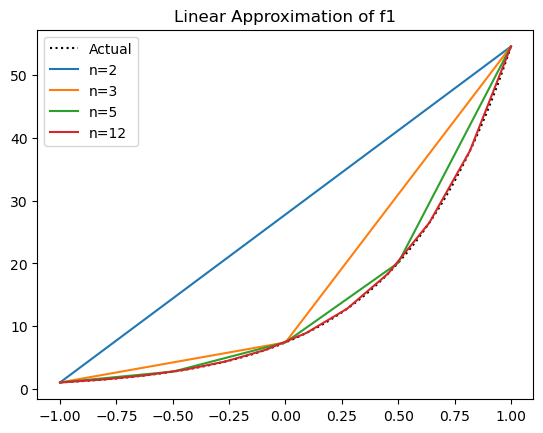

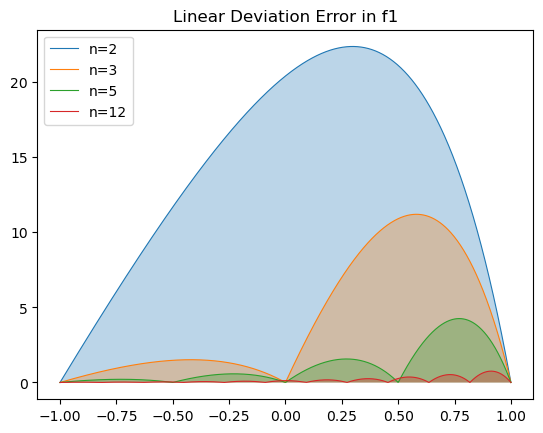

In [6]:
# Function #1: Linear Interpolation
n=[2,3,5,12]

f1_approx.plot(n, x, method="Linear")
f1_approx.plot_deviation(n, x, method="Linear")

__Comment:__ It appears that Linear interpolation struggles with the curvature of $f_{1}$, and consequently requires more interpolation nodes to approximate the function accurately. It also appears that, for a given $n$, the error increases slightly in the steeper ends of the function, where the equidistant interpolation nodes face greater curvature, resulting in greater deviation from the approximation.

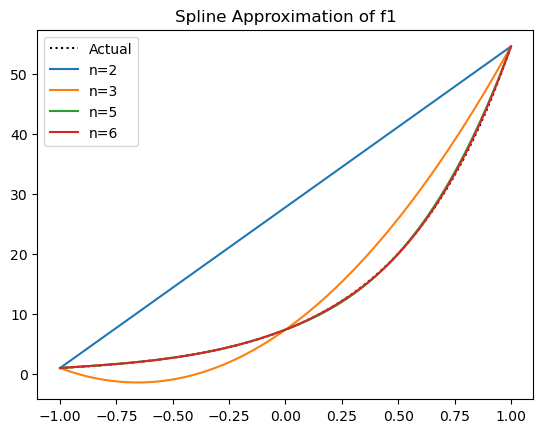

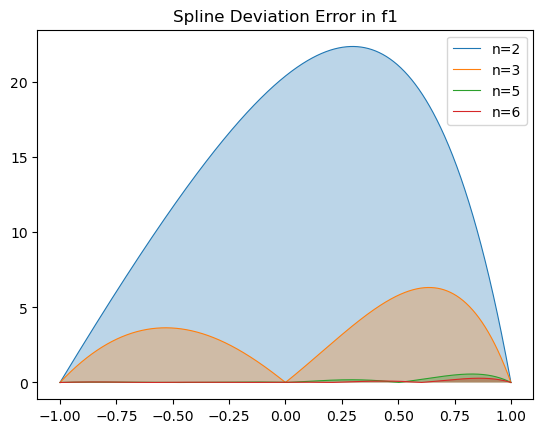

In [7]:
# Function #1: Cubic Splines
n=[2,3,5,6]

f1_approx.plot(n, x, method="Spline")
f1_approx.plot_deviation(n, x, method="Spline")

__Comment:__ We see that stitching together cubic polynomials approximates $f_{1}$ well, with a fairly accurate approximation at only $n=5$.

Note, in this specification, Scipy's CubicSplines requires >1 interpolation node to approximate anything. Actually, in general all the methods will create a horizontal line intersecting the minimum of the function if given only one interpolation node, except Chebysehv, which we explicity defined to have $n+1$ interpolation nodes.

In [8]:
# Define Function #2
def f2(x):
    return np.minimum(np.maximum(-1, 4*(x-1/5)),1)  #Looks a lot like ReLU + Clip

lower_b = -1
upper_b = 1

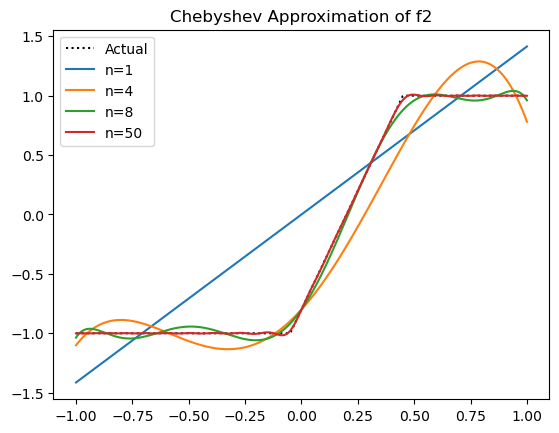

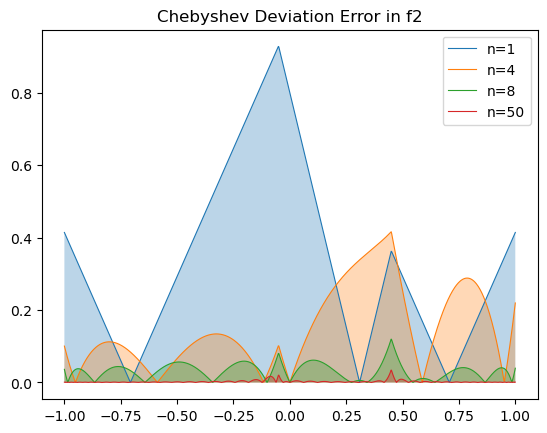

In [9]:
# Function #2: Chebyshev Polynomials

# start by creating an instance of the class
f2_approx = ApproxFunc(f2, bounds=[lower_b, upper_b])

# set parameters
n = [1,4,8,50]
x = np.linspace(lower_b, upper_b, 1000)

# call the plot methods
f2_approx.plot(n, x, method = "Chebyshev")
f2_approx.plot_deviation(n, x, method = "Chebyshev")

__Comment:__ Compared to the smooth curvature $f_{1}$, we see that Chebyshev struggles a lot more with kinks and discontinuities in derivative space. Even at n=50, we can see deviations from the actual function at these jagged parts, as Chebyshev tries to fit a curved line onto two intersecting straight lines.

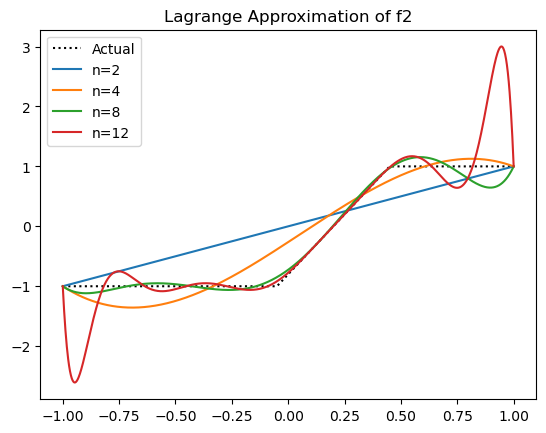

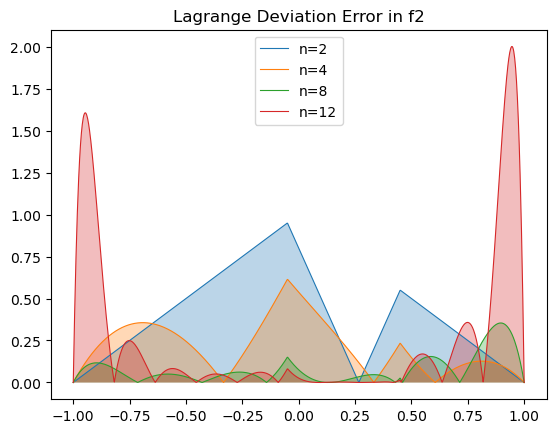

In [10]:
# Function #2: Lagrange Polynomials
n = [2,4,8,12]

f2_approx.plot(n, x, method = "Lagrange")
f2_approx.plot_deviation(n, x, method="Lagrange")

__Comment:__ In the case of Lagrange polynomials, we see divergent behavior in the deviation from the benchmark as $n$ increases with amplified oscilations at the bounds. Lagrange polynomials are significantly more sensitive to Runge's phenomenon than Chebyshev, as the high-degree polynomial with equidistant roots is forced to intersect the benchmark a greater number of times near the bounds. These dense intersections, combined with the extreme values of the high-degree polynomial at the extremes of the bounds contribute to oscillations with growing amplitudes in $n$.

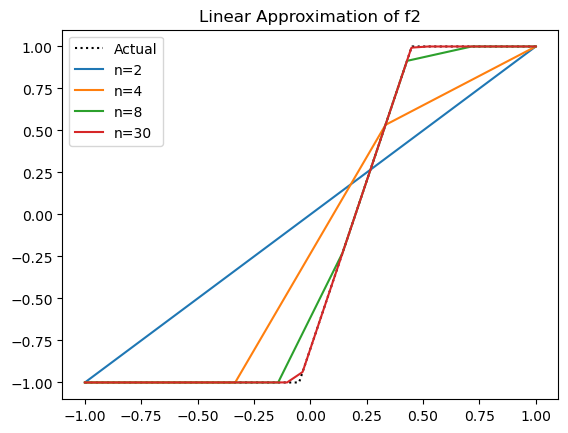

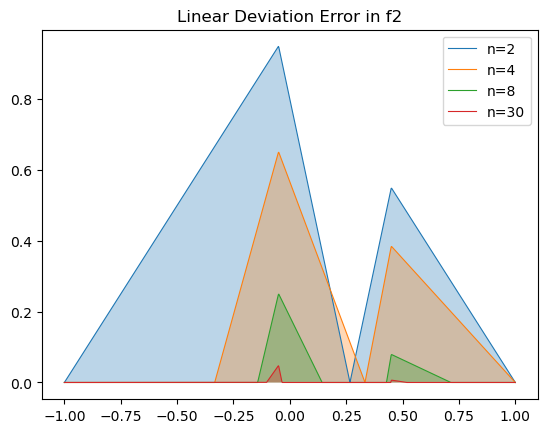

In [11]:
# Function #2: Linear Interpolation
n = [2,4,8,30]

f2_approx.plot(n, x, method = "Linear")
f2_approx.plot_deviation(n, x, method="Linear")

__Comment:__ Now that we are working with straight rather than curved lines, linear interpolation actually results in a relatively accurate approximation at $n=30$. However, this depends on whether the equidistant interpolation nodes happen to land relatively symmetrically on either side of the corner (thus creating a large area beneath their secant line and the corner), or whether one or both of the points are placed very closely to the point of the corner. Clearly, the probability of latter scenario grows relatively quickly with $n$.

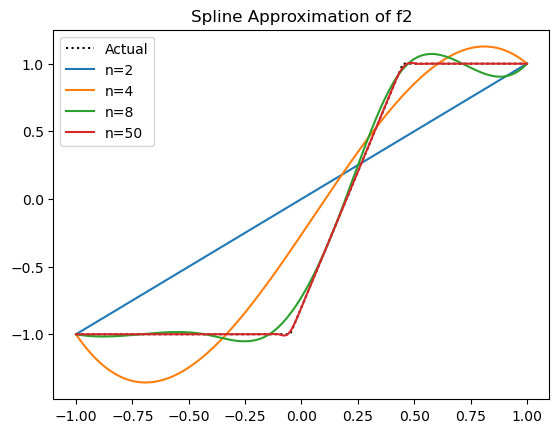

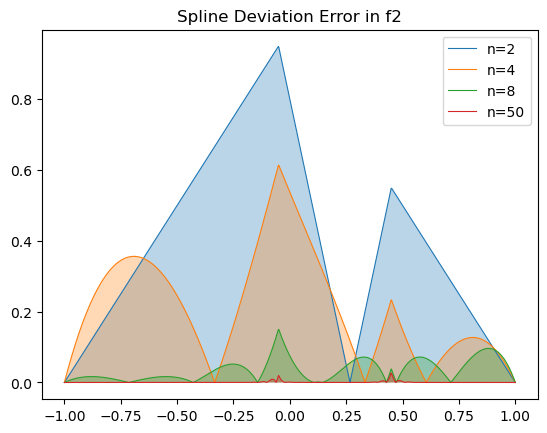

In [12]:
# Function #2: Cubic Splines
n = [2,4,8,50]

f2_approx.plot(n, x, method = "Spline")
f2_approx.plot_deviation(n, x, method="Spline")

For $f_{2}$, the knotted Cubic Splines perform practically identically (in terms of deviation from the benchmark) to the global Chebyshev polynomial. Both are relatively powerful ways of mitigating Runge's phenomenon and involve fitting curved lines onto the straight benchmark for large $n$. However, the fact that you practically only solve a system of equations for $n$ knots in cubic splines might favor this method, computationally.

In [4]:
# Define Function #3
def f3(x):
    return -2*x**(-1/2)

lower_b = 0
upper_b = 1

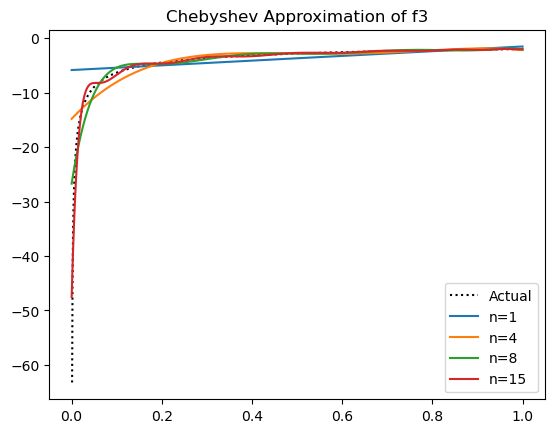

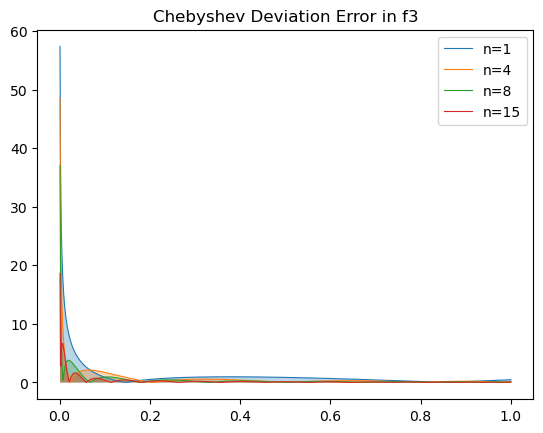

In [13]:
# Function #3: Chebyshev Polynomials

# start by creating an instance of the class
f3_approx = ApproxFunc(f3, bounds=[lower_b, upper_b])

# set parameters
n = [1,4,8,15]
x = np.linspace(lower_b, upper_b, 1000)

# call the plot methods
f3_approx.plot(n, x, method = "Chebyshev")
f3_approx.plot_deviation(n, x, method = "Chebyshev")

__Comment:__ Because $x^{-1/2}$ is undefined for $x=0$, Chebyhev is forced to fit to a curve that approaches perfect verticality as $x$ approaches 0 from the right. As a result, we see some oscillations in the neighboring region-- a wide turn is required to "slingshot" the end of the polynomial a large distance very quickly. 

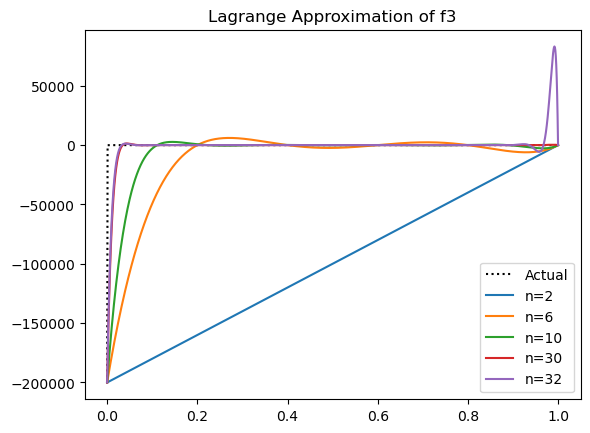

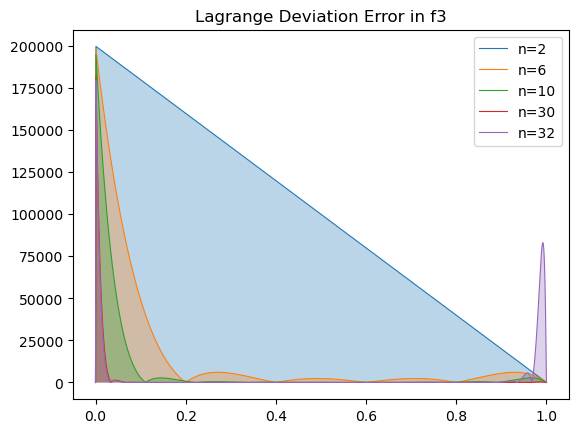

In [15]:
# Function #3: Lagrange Polynomial

# We need to adjust the approximation interval because f3(0)=undefined.
lower_b = 1e-10
upper_b = 1

# redefine the class
f3_approx = ApproxFunc(f3, bounds=[lower_b, upper_b])

# evaluate and plot the approximation
x = np.linspace(lower_b, upper_b, 1000)
n = [2,6,10,30,32]

f3_approx.plot(n, x, method = "Lagrange")
f3_approx.plot_deviation(n, x, method = "Lagrange")

__Comment:__ With $f_{3}$, the Lagrange polynomial approximation is put in a tough position. If $n$ is too low, it fails to fit to sharp asymptote around $x=0$. If $n$ is too high (and thus the global polynomial has a high degree) it succumbs to Runge's phenomenon, increasing the error once again. It appears that $n≈30$ finds a decent compromise between these two forces.

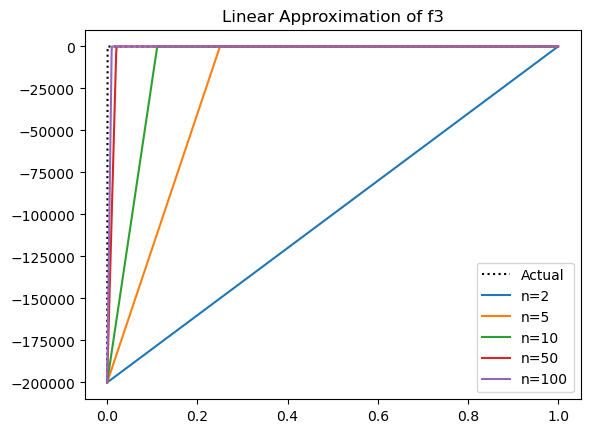

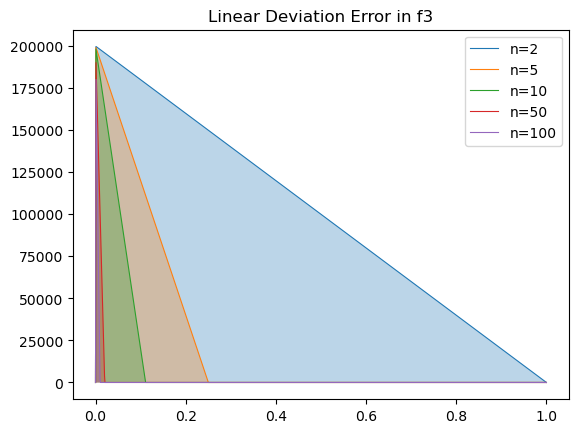

In [16]:
# Function #3: Linear Interpolation
  # Because interpolation nodes are chosen similar to Lagrange, we'll keep the readjusted bounds.
n = [2,5,10,50,100]

f3_approx.plot(n, x, method = "Linear")
f3_approx.plot_deviation(n, x, method = "Linear")

__Comment:__ Linear interpolation fairs relatively well for large $n$, which allows it to capure enough of the curvature between the vertical and horizontal asymptotes, as well as the linearity of the asymptotes at their extremes. However, its success is bounded; if the asymptote and n were allowed to grow without bound, then the linear interpolation would eventually become undefined.  

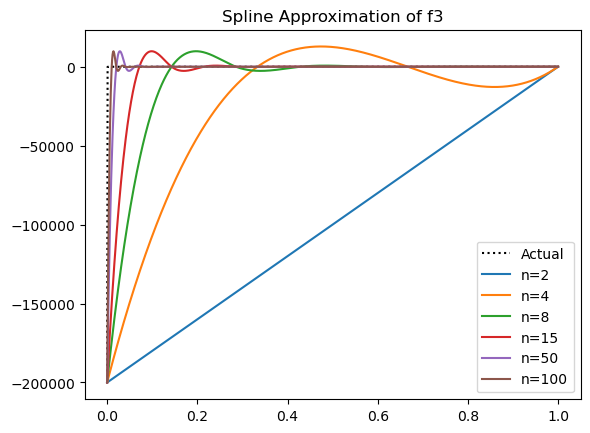

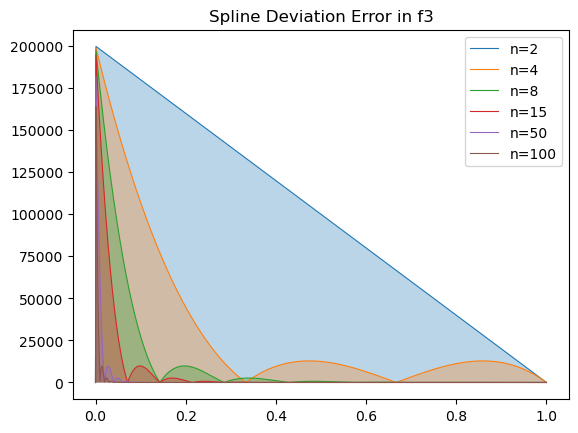

In [17]:
# Function #3: Cubic Splines
n = [2,4,8,15,50,100]

f3_approx.plot(n, x, method = "Spline")
f3_approx.plot_deviation(n, x, method = "Spline")

__Comment:__ Once again, Cubic Splines performs very similar to Chebyshev, except that the oscillations to the right of the asymptote are slightly more pronounced. Nevertheless, for large $n$ the error becomes very small at points surrounding the singularity. 

In [18]:
# Define Function #4
def f4(x):
    return 1/(1+x**2)

lower_b = -5
upper_b = 5

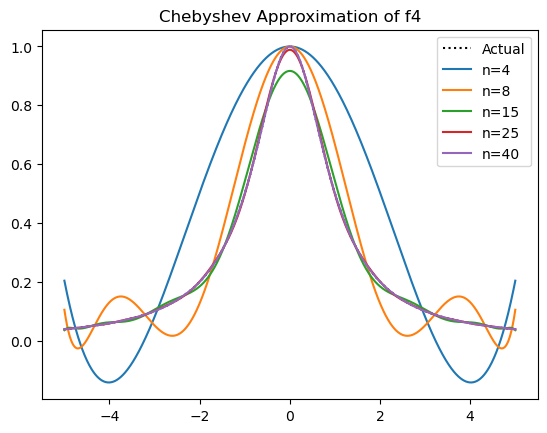

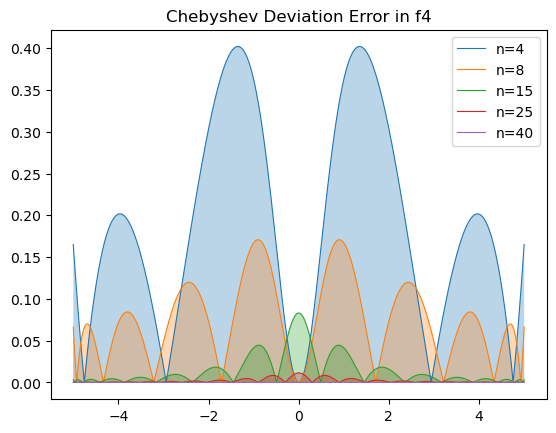

In [19]:
# Function #4: Chebyshev Polynomials

# start by creating an instance of the class
f4_approx = ApproxFunc(f4, bounds=[lower_b, upper_b])

# set parameters
n = [4,8,15,25,40]
x = np.linspace(lower_b, upper_b, 1000)

# call the plot methods
f4_approx.plot(n, x, method = "Chebyshev")
f4_approx.plot_deviation(n, x, method = "Chebyshev")

__Comment:__ With large enough $n$, Chebyshev manages to mitigate Runge's phenomenon with only mild oscillations near the bounds.

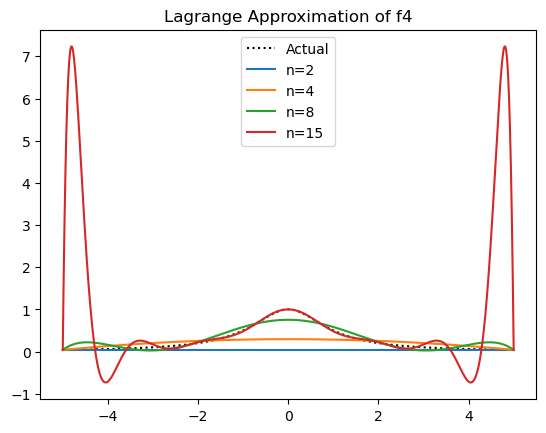

In [20]:
# Function #4: Lagrange Polynomial
n = [2,4,8,15]

f4_approx.plot(n, x, method = "Lagrange")
#f4_approx.plot_deviation(n, x, method = "Lagrange")

 __Comment:__ With equidistant interpolation nodes, the Lagrange polynomial fares less well. Near the bounds, the deviation of the approximation from the benchmark increases indefinitely as $n \rightarrow \infty$. In other words, in trying to fit to the hill in the center, the Lagrange polynomial becomes increasingly sensitive to Runge's phenomenon as the degree of the polynomial grows. 

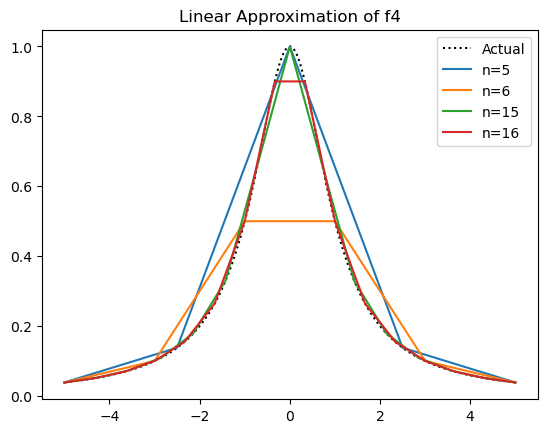

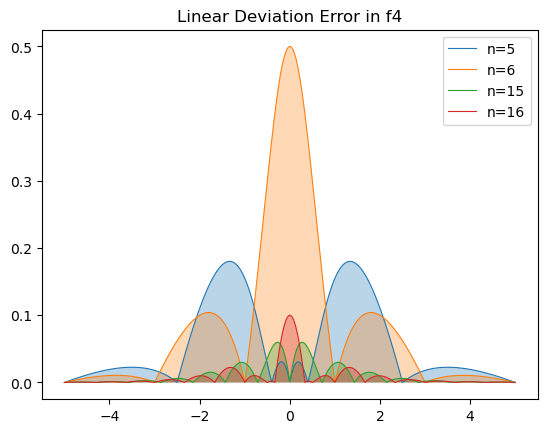

In [21]:
# Function #4: Linear Interpolation
n = [5,6,15,16]

f4_approx.plot(n, x, method = "Linear")
f4_approx.plot_deviation(n, x, method = "Linear")

__Comment:__ As we saw with the previous functions, linear interpolation fares poorly in areas of high curvature. 

One interesting pattern we noticed while adjusting $n$ was that for even $n$, two nodes are always on either sides of the maximum of the hill, and thus the connecting line is forced to cut through the hill. When $n$ is odd, an interpolation node is placed at the top of the hill, and the connecting lines for a sort of triangle rather than fitting to the curvature of the hill. Although this is a simple consequence of the symmetry of the function and its bounds, it results in some rather interesting visuals __:__

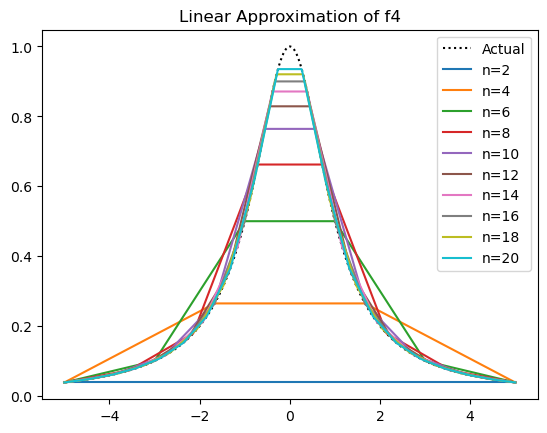

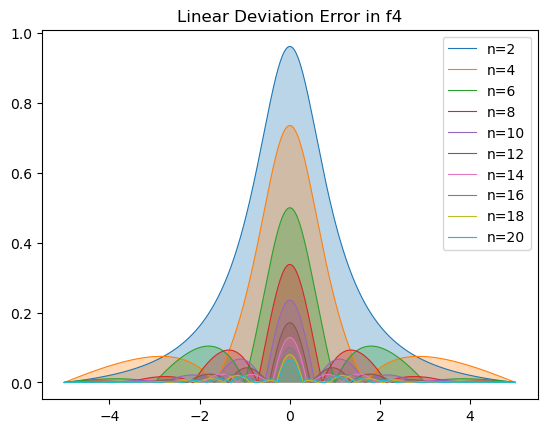

In [22]:
# Function #4: Linear Interpolation (even only)
n = np.arange(2,22,2)

f4_approx.plot(n, x, method = "Linear")
f4_approx.plot_deviation(n, x, method = "Linear")

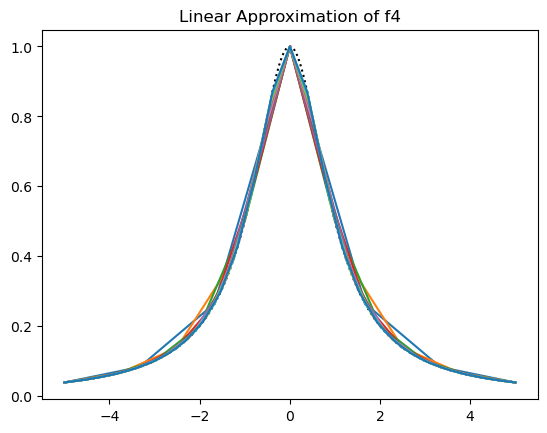

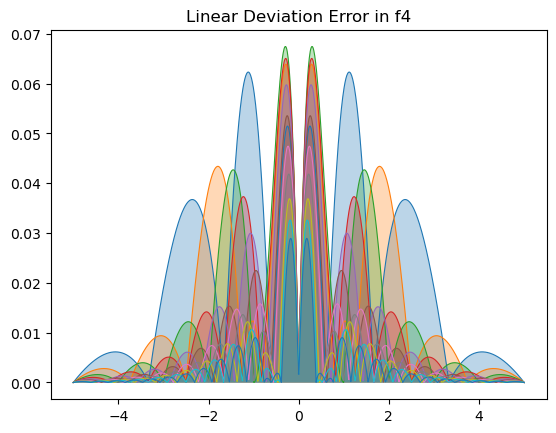

In [23]:
# Function #4: Linear Interpolation (odd only)
n = np.arange(7,28,2)

f4_approx.plot(n, x, method = "Linear", suppress_legend=True)
f4_approx.plot_deviation(n, x, method = "Linear", suppress_legend=True)

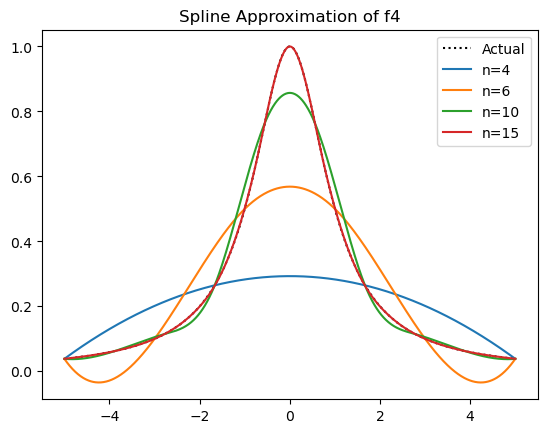

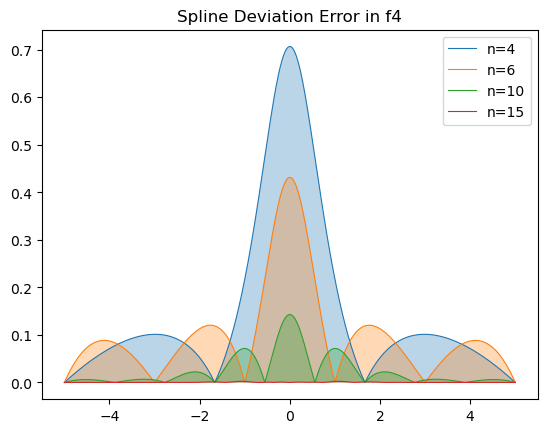

In [24]:
# Function #4: Cubic Splines
n = [4,6,10,15]

f4_approx.plot(n, x, method = "Spline")
f4_approx.plot_deviation(n, x, method = "Spline")

__Comment:__ The knitted Cubic Splines quickly become indistinguishable from $f_{4}$ after $n=15$.

#### (b) Let’s try to study the approximation errors more rigorously. Choose your favorite way to calculate the approximation error, $\| f - \hat{f} \|_2$. For each function $f_i$, calculate the approximation $\epsilon_{n}$ with each of the four methods you used in part (a) for $n = 5, 6, 7, 8, . . . , 1000$. Save the results in an array, and plot them against $n$. You will want to use a log-scale (i.e., log(n) on the x-axis, and log(n) on the y-axis). This will give you four plots, with four lines each. Interpret your results. What do the slopes tell you? Hint: Think about the rates of convergence for these methods.


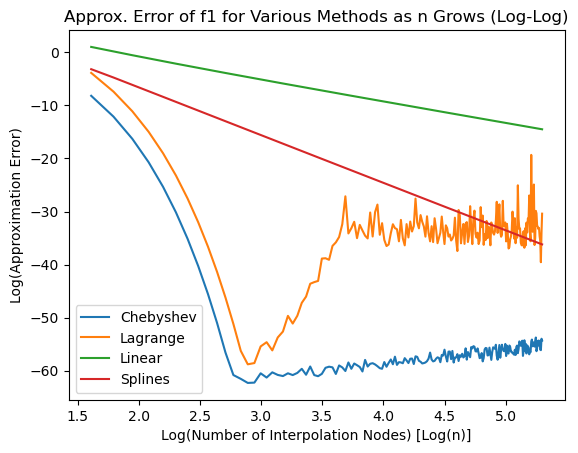

TOC: Elapsed: 0:00:33.83


33.83891940116882

In [25]:
# Function #1: Approximation Errors as n grows.

#Redefine the function and reset class just to be careful
def f1(x):
    return np.exp(2*x+2)

lower_b = -1
upper_b = 1

f1_approx = ApproxFunc(f1, bounds=[lower_b, upper_b])

# set parameters
n = np.arange(5,201,1)     #We cap it at n=300 due to computation time, but the general results are the same.
x = np.linspace(lower_b, upper_b, 1000)

qe.tic()
f1_approx.plot_node_error(n,x)
qe.toc()

__Comment:__ Plotting the norm of $f - \hat{f}$ for a large range of $n$ reveals the rate of convergence in log-log terms. As we saw previously, the global lagrange and chebyshev polynomials are susceptable to Runge's phenomenon (divergent oscillation near the bounds as $n$ grows), although the former is significantly more sensitive due to the equidistant interpolation nodes. The norm with linear approximation appears to converge, although at a much slower pace than cubic splines; in general, substantial curvature, such as in the case of $f_{1}$ requires a large number of secant lines to approximate accurately, and this leads to very slow convergence. The knitted local Cubic Spline polynomials are able to quickly fit to regions of high curvature as well as avoid Runge's phenomenon and thus will (probably) eventually converge with much higher accuracy. 

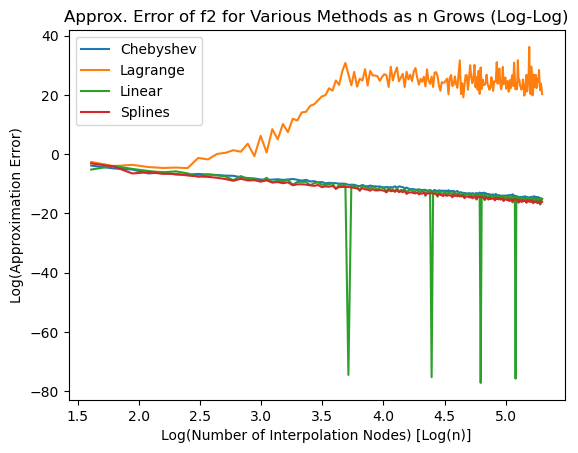

TOC: Elapsed: 0:00:31.88


31.884136199951172

In [26]:
# Function #2: Approximation Errors as n grows.
def f2(x):
    return np.minimum(np.maximum(-1, 4*(x-1/5)),1)  #Looks a lot like ReLU + Clip

lower_b = -1
upper_b = 1

f2_approx = ApproxFunc(f2, bounds=[lower_b, upper_b])
x = np.linspace(lower_b, upper_b, 1000)

qe.tic()
f2_approx.plot_node_error(n,x)
qe.toc()

__Comment:__ For F2 we can see that the Lagrange method is particularly ineffective and begins diverging after a relatively small n. The other three methods appear to be relatively similar in convergence terms. The Linear interpolation methods achieves a significantly lower approximation error for certain values of n. 

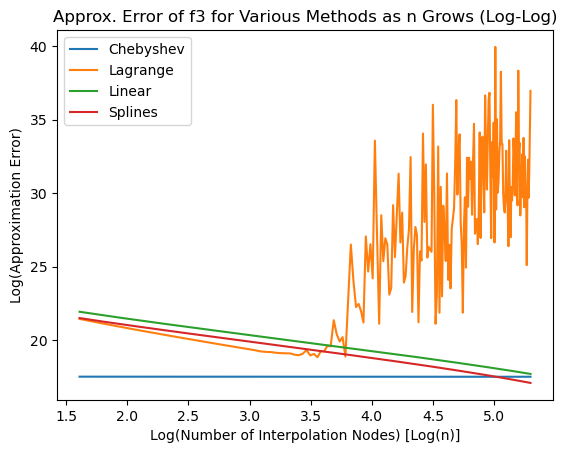

TOC: Elapsed: 0:00:32.67


32.674689054489136

In [27]:
# Function #3: Approximation Errors as n grows.
def f3(x):
    return -2*x**(-1/2)

lower_b = 1e-10
upper_b = 1

f3_approx = ApproxFunc(f3, bounds=[lower_b, upper_b])
x = np.linspace(lower_b, upper_b, 1000)

qe.tic()
f3_approx.plot_node_error(n,x)
qe.toc()

__Comment:__ For F3 chebyshev has the lowest approximation errors from the onset, while splines converge relatively quickly. Linear interpolation has a similar performance and the Lagrange method once again begins to diverge after some n.

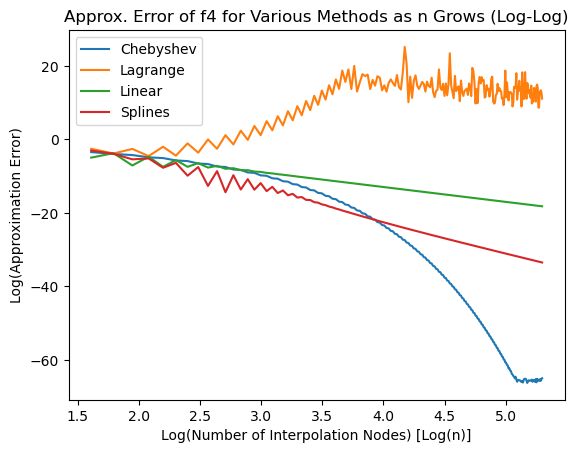

TOC: Elapsed: 0:00:29.69


29.694803953170776

In [28]:
# Function #4: Approximation Errors as n grows.
def f4(x):
    return 1/(1+x**2)

lower_b = -5
upper_b = 5

f4_approx = ApproxFunc(f4, bounds=[lower_b, upper_b])
x = np.linspace(lower_b, upper_b, 1000)

qe.tic()
f4_approx.plot_node_error(n,x)
qe.toc()

__Comment:__ For this function we clearly see the Runge phenomenon for the Lagrange method, and very quick convergence for the Chebyshev method compared to the others. Splines also perform relatively well.

# Problem 2.

### a) 
Start with a = −10, b = 0.5, α = 1/2 and β = 0.9. Write code that solves eq. (2) for any choice of k.
3
Try it out for k = 0.5, 1, 5, and 9, and find a sensible way to visualize the results.4

In [29]:
# Define utility function

def v(k, a, b):
    return a + b*np.log(k)

def min_problem(k_prime,k,a,b,α,β):   
    c = k**α - k_prime
    return -(np.log(c) + β*v(k_prime, a,b))    #In minimizing the negative, we are implicity maximizing

In [30]:
# Set parameters
k=0.5
a=-10
b=0.5
α=1/2
β=0.9

upper_b = k**α  #This follows from the equality and the two inequality constraints
lower_b = 0
bnds = [(lower_b, upper_b)]

#Solve the (implicit) maximization problem:

k_prime_init = np.random.rand(1)*k**α  #Ineq constraints implicitly define bounds for k', including the initial guess.
minimize(min_problem, k_prime_init, args=(k,a,b,α,β),bounds=bnds)

      fun: 10.704125095586098
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.01571468])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 6
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([0.05952443])

__Comment:__ Defining the inequality constraint implicitly via the bounds leads to significantly higher sensitivity to the random guess (we guess it could be the problem of generating loacal max/min value). We found that defining the constraints explicitly lead to greater robustness to the initial guess. Below is our constraint method for solving eq(2) for any choice of k:

In [31]:
def ineq_const1(k_prime, k, α):
    c = np.power(k,α) - k_prime
    return c

def ineq_const2(k_prime, k, α):
    c = np.power(k,α) - k_prime
    return np.power(k,α) - c

In [32]:
# Set parameters
k=0.5
a=-10
b=0.5
α=1/2
β=0.9

cons = [
    {'type': 'ineq', 'fun': lambda k_prime: ineq_const1(k_prime, k, α)}, # c >= 0
    {'type': 'ineq', 'fun': lambda k_prime: ineq_const2(k_prime, k, α)}, # c <= k**a
    ]

upper_b = k**α
lower_b = 0
bnds = [(lower_b, upper_b)]
k_prime_init = np.random.rand(1)*upper_b 

#Solve the (implicit) maximization problem:
minimize(min_problem, k_prime_init, args=(k,a,b,α,β), constraints=cons, bounds=bnds)

     fun: 10.40062732623294
     jac: array([-0.00520313])
 message: 'Optimization terminated successfully'
    nfev: 14
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.21944147])

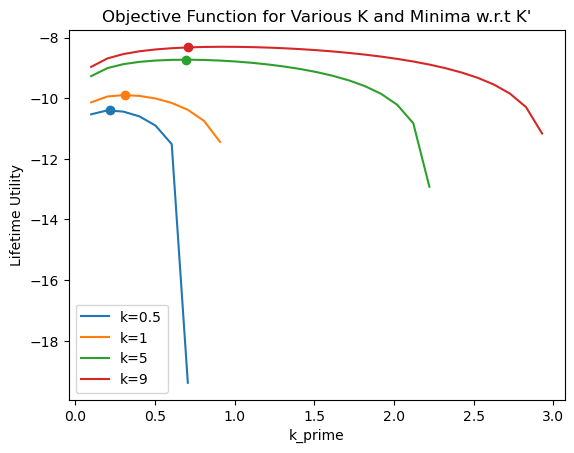

In [33]:
# Visualize the objective function for various k

#Set parameters
a=-10
b=0.5
α=1/2
β=0.9
k=[0.5,1,5,9]

fig, ax = plt.subplots()
result_bin = []
k_primes = np.linspace(0,10,100)
fun_bin = []
for i in k:
    upper_b = i**α
    lower_b = 0
    bnds = [(lower_b, upper_b)]
    k_prime_init = np.random.rand(1)*upper_b 
    
    cons1 = {'type': 'ineq', 'fun': ineq_const1, 'args': (i, α)}
    cons2 = {'type': 'ineq', 'fun': ineq_const2, 'args': (i, α)}
    res = minimize(min_problem, k_prime_init, args=(i,a,b,α,β), constraints=cons, bounds=bnds)
    result_bin.append(res.x)  #Optimal k' given k
    fun_bin.append(res.fun)
    obj_vals = min_problem(k_primes,i,a,b,α,β)
    ax.plot(k_primes, -1*obj_vals, label=f"k={i}")  #Inverts the minimization problem to show the actual values of utility
    ax.scatter(res.x, -1*res.fun)
ax.set_title("Objective Function for Various K and Minima w.r.t K'")
ax.set_xlabel("k_prime")
ax.set_ylabel("Lifetime Utility")
plt.legend()
plt.show()

__Comment:__ Plotting four different objective functions under different k. We found that as k increases, the overall utility tends to increase. This is because our resource constraint (the total capatal constraint),is k in the power of alpha. As k increases, the individual is endowed with more capital (like the famouse cake-eating problem, the total size of the cake increases). Moreover, as k increases, the individual will tend to choose consume more at current period, as you could see the optimal choice is moving to the right. The circles indicate the optimal k' found from our maximisation method. As visible on the graph each of the circles is at the maximal point of the eq(2) given the constraint, implying our method works.

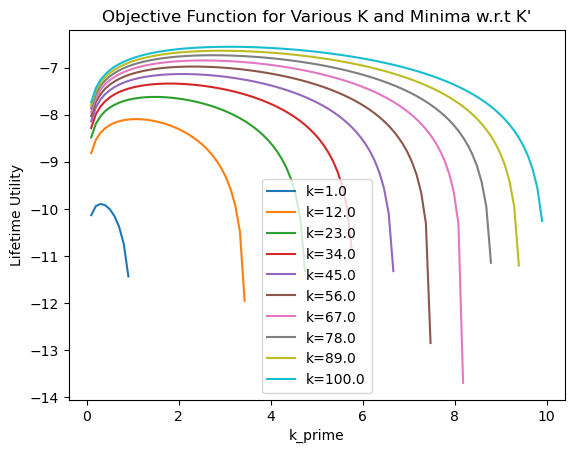

In [34]:
# Visualize the objective function for a lot more k

#Set parameters
a=-10
b=0.5
α=1/2
β=0.9
k=np.linspace(1,100,10)

fig, ax = plt.subplots()
result_bin = []
k_primes = np.linspace(0,10,100)
fun_bin = []
for i in k:
    k_prime_init = np.random.rand(1)*i**α 
    cons1 = {'type': 'ineq', 'fun': ineq_const1, 'args': (i, α)}
    cons2 = {'type': 'ineq', 'fun': ineq_const2, 'args': (i, α)}
    res = minimize(min_problem, k_prime_init, args=(i,a,b,α,β), constraints=cons)
    result_bin.append(res.x)  #Optimal k' given k
    fun_bin.append(res.fun)
    obj_vals = min_problem(k_primes,i,a,b,α,β)
    ax.plot(k_primes, -1*obj_vals, label=f"k={i}")  #Inverts the minimization problem to show the actual values of utility
 #  ax.scatter(res.x, -1*res.fun)
    #ax.vlines(result_bin, 8, 18)
#    ax.hline(res.x)
#ax.vlines(result_bin, 8, 18)
ax.set_title("Objective Function for Various K and Minima w.r.t K'")
ax.set_xlabel("k_prime")
ax.set_ylabel("Lifetime Utility")
plt.legend()
plt.show()

__Comment:__ Here we plot objective functions for a lot more k. We found the individual's utitlity becomes larger when we increases k, which is consistent with our above conclusion. 

__Comment:__ We are dealing with a Bellman equation optimization problem in this question. From our research,we also found envelope theorem is used in solving this kind of question. By using envelope theorem and convexity, we just need to focus on the uppear envelope of convex functions.

However, we are dealing with endogenous variable change (different k values) here. Notice that the envelope theorem could only deal with questions with exogenous variable change. Thus, envelope theorem could not be used in explaining this question. 

#### b) Now, suppose you cannot use v directly in solving eq. (2) (for instance, imagine that it is costly to evaluate). Instead, you must use an approximation ˆv. Approximate v using linear interpolation, cubic splines, and Chebyshev polynomials, for n = 5, 20 and 100.5 Re-solve eq. (2) using ˆv instead of v. Compare (and visualize) your results. How similar are the optimized values? How close are the implied optimal choices of c and k0? Which approximation algorithm generates the best results (and why)? What do you take away from this?

For this part of the question we once again use the class we created at the start of the problem set to approximate the functions.

In [35]:
#Redefine the maximization problem to use approximated values of v(k)

def min_problem(k_prime, k, a, b, α, β, n, method="Chebyshev"):
    v_short = lambda k: v(k,a,b)
    upper_bound = k**α
    v_approx = ApproxFunc(v_short,[1e-15,upper_bound+1e-15])
    
    if method == "Chebyshev":    
        approx_vals = v_approx.ChebyshevPoly(n, k_prime)
    elif method == "Lagrange":
        approx_vals = v_approx.LagrangePoly(n, k_prime)   
    elif method == "Linear":
        approx_vals = v_approx.LinearInterp(n, k_prime)
    elif method == "Spline":
        approx_vals = v_approx.CubicSplines(n, k_prime)
    
    c = k**α - k_prime
    return -(np.log(c) + β*approx_vals)

# repeat constraints for reference
def ineq_const1(k_prime, k, α):
    return k_prime

def ineq_const2(k_prime, k, α):
    return k**α - k_prime

# set parameters
k=0.5
a=-10
b=0.5
α=1/2
β=0.9
n=100      #Number of interpolation nodes

cons1 = {'type': 'ineq', 'fun': ineq_const1, 'args': (k, α)}
cons2 = {'type': 'ineq', 'fun': ineq_const2, 'args': (k, α)}
cons = [cons1, cons2]

lower_b = 0
upper_b = k**α
bnds = [(lower_b, upper_b)]

k_prime_init = np.random.rand(1)*upper_b

min_short = lambda k_prime, k, a, b, α, β, n: min_problem(k_prime, k, a, b, α, β, n, method="Spline")
minimize(min_short, k_prime_init, args=(k,a,b,α,β,n), constraints=cons, bounds=bnds)


     fun: 10.400627320804869
     jac: array([-0.00428331])
 message: 'Optimization terminated successfully'
    nfev: 8
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.21945054])

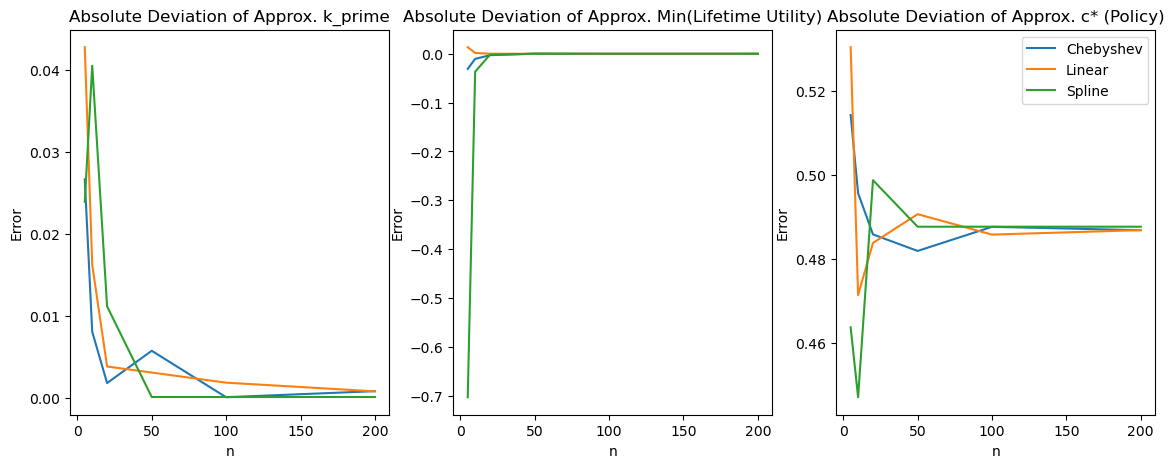

In [36]:
# Plot and compare Chebyshev, Linear, Spline for Various n
b_methods = ["Chebyshev", "Linear", "Spline"]
n=[5,10,20,50,100,200]

fig,ax=plt.subplots(1,3, figsize=(14,5))

for i in b_methods:
    fun_error_bin = []
    argmin_error_bin = []
    policy_bin = []
    min_short = lambda k_prime, k, a, b, α, β, n: min_problem(k_prime, k, a, b, α, β, n, method=i)
    for j in n:
        res = minimize(min_short, k_prime_init, args=(k,a,b,α,β,j), constraints=cons, bounds=bnds)
        argmin_error = abs(res.x - 0.21951255)
        argmin_error_bin.append(argmin_error)
        fun_error = (res.fun - 10.400627326103546)
        fun_error_bin.append(fun_error)
        policy = k**α - res.x
        policy_bin.append(policy)
    ax[0].plot(n, argmin_error_bin, label=f"{i}")
    ax[1].plot(n, fun_error_bin, label=f"{i}")
    ax[2].plot(n, policy_bin, label=f"{i}")
ax[0].set_title("Absolute Deviation of Approx. k_prime")
ax[1].set_title("Absolute Deviation of Approx. Min(Lifetime Utility)")
ax[2].set_title("Absolute Deviation of Approx. c* (Policy)")
ax[0].set_xlabel("n")
ax[1].set_xlabel("n")
ax[2].set_xlabel("n")
ax[0].set_ylabel("Error")
ax[1].set_ylabel("Error")
ax[2].set_ylabel("Error")
plt.legend()
plt.show()

__Comment:__ As n increase, firstly it shows some oscillations when n is small, but the optimized value tends to 0 when n is large. For the implied optimal choices, they are nearly equal to what we got from (a). We found the Chebyshev method might generate the best results, since this utility function is smooth and bounded firstly. Furthermore, compared with linear interpolation, it converges faster. The key takeaway is that for n>100 almost all approximation methods appear to quite accurate predictions of the true values.

#### c) With the parameters you used in part (a), check whether or not this problem has the property from the problem set. You should verify this on a grid of points. Check it for every k on an evenly spaced grid of 100 points from 0.1 to 10. Plot the difference between your max values and the v you started with.

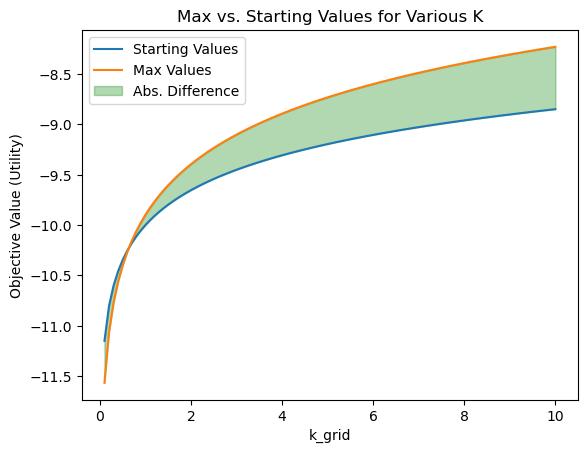

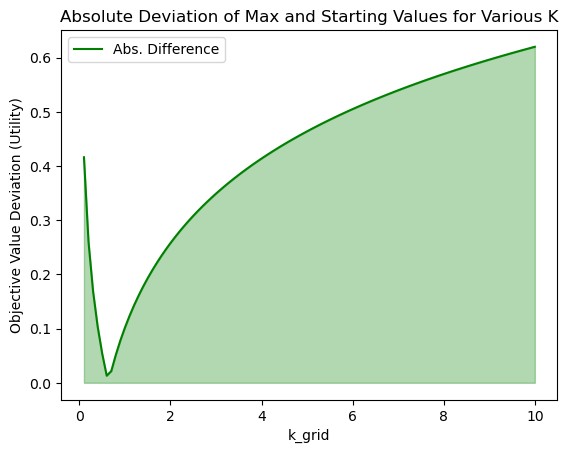

In [37]:
# Parameters from part a).
a=-10
b=0.5
α=1/2
β=0.9

def v(k, a, b):
    return a + b*np.log(k)

def min_problem(k_prime,k,a,b,α,β):   
    c = k**α - k_prime
    return -(np.log(c) + β*v(k_prime, a,b))

def ineq_const1(k_prime, k, α):
    c = np.power(k,α) - k_prime
    return c

def ineq_const2(k_prime, k, α):
    c = np.power(k,α) - k_prime
    return np.power(k,α) - c



k_grid = np.linspace(0.1,10,100)

v_bin = []
bell_bin = []
c_bin = []

for i in k_grid: 
    upper_b = i**α  
    lower_b = 0
    bnds = [(lower_b, upper_b)]

    cons = [
        {'type': 'ineq', 'fun': lambda k_prime: ineq_const1(k_prime, i, α)}, # c >= 0
        {'type': 'ineq', 'fun': lambda k_prime: ineq_const2(k_prime, i, α)}, # c <= k**a
        ]
    k_prime_init = np.random.rand(1)*i**α
    res = minimize(min_problem, k_prime_init, args=(i,a,b,α,β), constraints=cons, bounds=bnds)
    bell_val = -1*res.fun
    bell_bin.append(bell_val)
    v_val = v(i,a,b)
    v_bin.append(v_val)
    
bell_bin = np.array(bell_bin)
v_bin = np.array(v_bin)

# Plot the max, starting values and their absolute difference
fig, ax = plt.subplots()
ax.plot(k_grid, v_bin, label="Starting Values")
ax.plot(k_grid, bell_bin, label="Max Values")
ax.fill_between(k_grid, bell_bin, v_bin, color="green", alpha=0.3, label="Abs. Difference")
ax.set_title("Max vs. Starting Values for Various K")
ax.set_xlabel("k_grid")
ax.set_ylabel("Objective Value (Utility)")
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(k_grid, abs(bell_bin-v_bin), color="green", label="Abs. Difference")
ax.fill_between(k_grid, abs(bell_bin-v_bin), color="green", alpha=0.3)
ax.set_title("Absolute Deviation of Max and Starting Values for Various K")
ax.set_xlabel("k_grid")
ax.set_ylabel("Objective Value Deviation (Utility)")
plt.legend()
plt.show()

__Comment:__ As we increases k on an evenly spaced grid space, we found that starting value of value function is larger than the maximum value of value function at first, but later this appears to invert. Also the absolute difference between these two values become larger when k increase. This implies that the misspecification of parameter a and b has a greater impact the higher the k. 

### d)

In [38]:
# Parameters from part a).
a=-10
b=0.5
α=1/2
β=0.9

#Eq.(2) specification
def v(k, a, b):
    return a + b*np.log(k)

def min_problem(k_prime,k,a,b,α,β):   
    c = k**α - k_prime
    return -(np.log(c) + β*v(k_prime, a,b))

def ineq_const1(k_prime, k, α):
    c = np.power(k,α) - k_prime
    return c

def ineq_const2(k_prime, k, α):
    c = np.power(k,α) - k_prime
    return np.power(k,α) - c

#Procedure Step #1 - Collect V vector
k_grid = np.linspace(0.1,10,5)

v_vector = []
for i in k_grid: 
    upper_b = i**α  
    lower_b = 0
    bnds = [(lower_b, upper_b)]

    cons = [
        {'type': 'ineq', 'fun': lambda k_prime: ineq_const1(k_prime, i, α)}, # c >= 0
        {'type': 'ineq', 'fun': lambda k_prime: ineq_const2(k_prime, i, α)}, # c <= k**a
        ]
    k_prime_init = np.random.rand(1)*i**α
    res = minimize(min_problem, k_prime_init, args=(i,a,b,α,β), constraints=cons, bounds=bnds)
    v_i = -1*res.fun
    v_vector.append(v_i)
    
print(v_vector)

[-11.567470187959037, -9.212354708018458, -8.724039426434924, -8.434878283357609, -8.228721435782349]


In [39]:
#Procedure Step #2 - Find values of a and b that solve the new minimization problem.

def min_problem2(x,v_vector,k_grid):
    a,b = x
    sigma = 0
    for i,j in zip(v_vector,k_grid):
        summand = (i - a - b*np.log(j))**2
        sigma += summand
    return sigma
        
x_init = [-10,0.5]
res = minimize(min_problem2, x_init, args=(v_vector,k_grid))

print(res)
print()
print(f"a* = {res.x[0]}") 
print(f"b* = {res.x[1]}")  

      fun: 6.078813751935773e-14
 hess_inv: array([[ 0.91121848, -0.28095874],
       [-0.28095874,  0.11459296]])
      jac: array([5.83829214e-08, 2.09401566e-07])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 2
     njev: 5
   status: 0
  success: True
        x: array([-9.89809582,  0.72500007])

a* = -9.898095819012033
b* = 0.7250000696238791


a* = -12.511598105741173
b* = 0.9090903366531357
Number of Iterations: 115
Error: 0.0


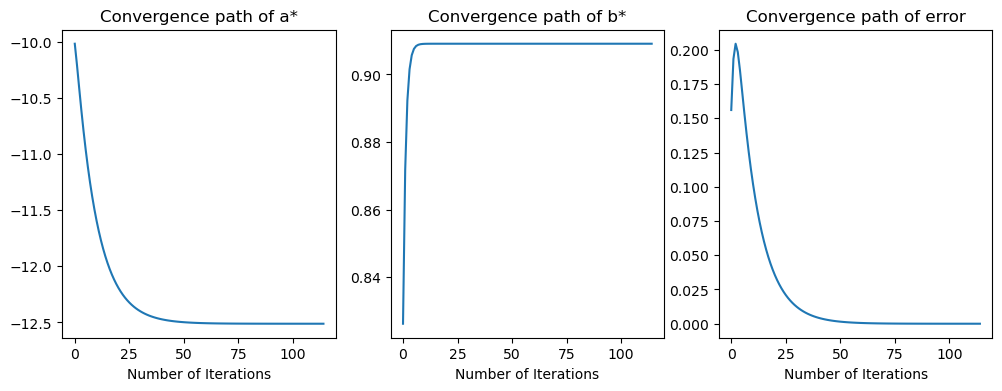

In [40]:
# Procedure Step #3: a,b while loop

#Parameters
k_grid = np.linspace(0.1,10,5)
tol = 1e-7

#Initialize the while loop
x_init = np.array([-10,0.5])
res = minimize(min_problem2, x_init, args=(v_vector,k_grid))
x_new = np.array([res.x[0], res.x[1]])

error = np.linalg.norm(x_init - x_new)

counter = 0
#while loop    - Need to re-run first cell of d) to see convergence path
a_bin = []
b_bin = []
error_bin = []
while error > tol:
    counter += 1
    x_init = x_new
    
    #Step 1
    v_vector = []
    for i in k_grid: 
        upper_b = i**α  
        lower_b = 0
        bnds = [(lower_b, upper_b)]

        cons = [
            {'type': 'ineq', 'fun': lambda k_prime: ineq_const1(k_prime, i, α)}, # c >= 0
            {'type': 'ineq', 'fun': lambda k_prime: ineq_const2(k_prime, i, α)}, # c <= k**a
            ]
        a,b = x_init
        k_prime_init = np.random.rand(1)*i**α
        res = minimize(min_problem, k_prime_init, args=(i,a,b,α,β), constraints=cons, bounds=bnds)
        v_i = -1*res.fun
        v_vector.append(v_i)
    
    #Step 2
    res = minimize(min_problem2, x_init, args=(v_vector,k_grid))
    x_new = res.x
    a_bin.append(x_new[0])
    b_bin.append(x_new[1])
    error = np.linalg.norm(x_init - x_new)
    error_bin.append(error)
    if error < tol:
        break

print(f"a* = {x_new[0]}")
print(f"b* = {x_new[1]}")
print(f"Number of Iterations: {counter}")
print(f"Error: {error}")

fig,ax = plt.subplots(1,3, figsize=(12,4))
ax[0].plot(a_bin)
ax[0].set_title("Convergence path of a*")
ax[0].set_xlabel("Number of Iterations")

ax[1].plot(b_bin)
ax[1].set_title("Convergence path of b*")
ax[1].set_xlabel("Number of Iterations")

ax[2].plot(error_bin)
ax[2].set_title("Convergence path of error")
ax[2].set_xlabel("Number of Iterations")

plt.show()

__Comment:__ In the above plots we show the convergence path of a*, b* and the error term. By interating 115 times, we got a* equals to -12.511598105741173 and 
b* equals to 0.9090903366531357. We see that b converges a lot more quickly that a.

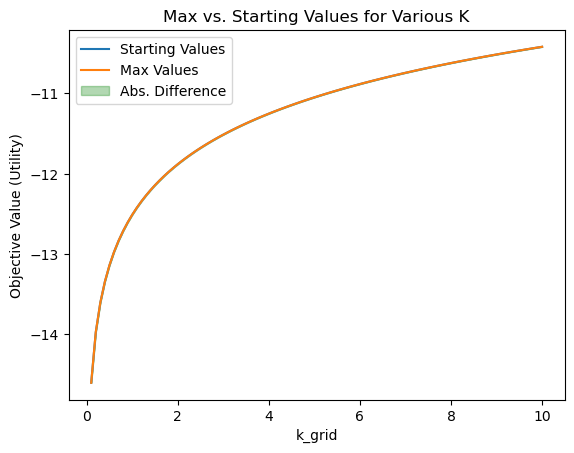

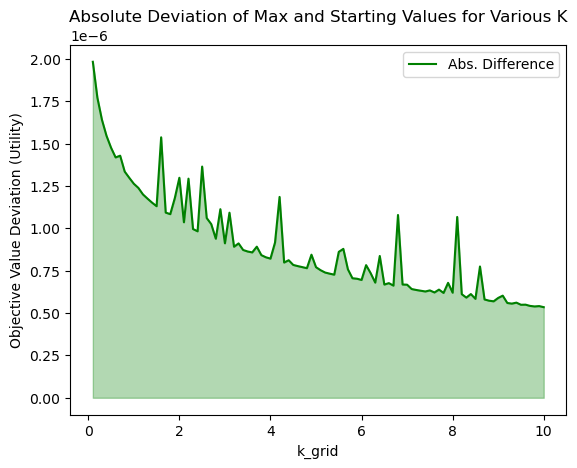

In [41]:
# Answer c again with new values a*, b*

#Parameters
a,b = x_new
α=1/2
β=0.9

#Functional specification
def v(k, a, b):
    return a + b*np.log(k)

def min_problem(k_prime,k,a,b,α,β):   
    c = k**α - k_prime
    return -(np.log(c) + β*v(k_prime, a,b))

def ineq_const1(k_prime, k, α):
    c = np.power(k,α) - k_prime
    return c

def ineq_const2(k_prime, k, α):
    c = np.power(k,α) - k_prime
    return np.power(k,α) - c


#Loop over the grid of k-values
k_grid = np.linspace(0.1,10,100)

v_bin = []
bell_bin = []
c_bin = []
for i in k_grid: 
    upper_b = i**α  
    lower_b = 0
    bnds = [(lower_b, upper_b)]

    cons = [
        {'type': 'ineq', 'fun': lambda k_prime: ineq_const1(k_prime, i, α)}, # c >= 0
        {'type': 'ineq', 'fun': lambda k_prime: ineq_const2(k_prime, i, α)}, # c <= k**a
        ]
    k_prime_init = np.random.rand(1)*i**α
    res = minimize(min_problem, k_prime_init, args=(i,a,b,α,β), constraints=cons, bounds=bnds)
    bell_val = -1*res.fun     #Collect the maximum values
    bell_bin.append(bell_val)
    v_val = v(i,a,b)         #Collect the starting values
    v_bin.append(v_val)
    
bell_bin = np.array(bell_bin)
v_bin = np.array(v_bin)

# Plot the max, starting values and their absolute difference
fig, ax = plt.subplots()
ax.plot(k_grid, v_bin, label="Starting Values")
ax.plot(k_grid, bell_bin, label="Max Values")
ax.fill_between(k_grid, bell_bin, v_bin, color="green", alpha=0.3, label="Abs. Difference")
ax.set_title("Max vs. Starting Values for Various K")
ax.set_xlabel("k_grid")
ax.set_ylabel("Objective Value (Utility)")
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(k_grid, abs(bell_bin-v_bin), color="green", label="Abs. Difference")
ax.fill_between(k_grid, abs(bell_bin-v_bin), color="green", alpha=0.3)
ax.set_title("Absolute Deviation of Max and Starting Values for Various K")
ax.set_xlabel("k_grid")
ax.set_ylabel("Objective Value Deviation (Utility)")
plt.legend()
plt.show()

__Comment:__ Under new a and b value, we found that the absoulte difference of value function and maximisation problem is almost neglegible and has a decreasing trend as k increases. The key finding is that with correctly specified a and b we find that this problem has the property we tested in c and the starting values are the same as the maximisation values for all of the k_grid. This implies that value function iteration is a very powerful tool in trying to solve economic models and when correctly performed can provide good solutions to difficult problems.